# Convolutional Neural Networks for classification


In [ ]:
# If PyTorch is not installed, please do so with the command(s) below, should be ok in Colab:
!pip install torch
!pip install torchvision

## Why GPUs?
Is it really so important to use GPU versus CPU for matric calculations? Let's examine. First of all, let's double check that a GPU (cuda) is detected in your runtime:

In [ ]:
import torch

print("PyTorch version:")
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Now that you know the name of your GPU device, we can do a matrix multiplication specifically on this device. Let's try something simple like $X \times X^t$. We will fill the matrix $X$ with random numbers and it will have dimensions $n=3000$).

In [ ]:
n = 3000
x = torch.rand(n,n)
print(x.shape)
print(x.dtype)

Let's do a simple matrix multiplicaton using the **C**PU and register the time it takes to execute:

In [ ]:
import time
start_time = time.time()

x.matmul(x.t())

print ('The elapsed time is {}'.format(time.time()-start_time) +' seconds.') #print the elapsed time

Now let's use our GPU to perform the same multiplication:

In [ ]:
x=x.to(device) #send our tensor to GPU, this does take time when executing for the first time

print(x.device) #check that this says cuda

start_time = time.time()
x.matmul(x.t())

print ('The elapsed time is {}'.format(time.time()-start_time) +' seconds.')

So much faster!

Leveraging the GPU for matrix operations is so important in CNNs due to the convolution operation, which is in essence a matrix multiplication. So let's have a look how convolution speeds up. We will be using PyTorch to do a 2D convolution with a $32\times7\times7\times3$ filter for 100 images with random pixels ($100\times100$ with 3 channels).

We can use the exact same Conv2D function for these two tests, except, we use  another device. We can do this by using .to(device) function, where our device='cuda' or 'cpu'. To make it easy, we define two functions for this: cpu_conv and gpu_conv. We also demonstrate a slightly different way to time operations using the `timeit` library.


In [ ]:
import torch.nn as nn
import timeit

# function to generate random image and run convolution on CPU
def cpu_conv():
    random_image_cpu = torch.randn(100, 3, 100, 100) # 100 images (batch size), 3 channels, 100x100 height and width -> [B,C,H,W]
    cpuconv2=nn.Conv2d(3, 32, 7) #3 input channels, 32 output channels (number of filters), 7 kernel size (7x7 width and height)
    cpuout=cpuconv2(random_image_cpu)
    return cpuout

# function to generate random image, move it to GPU device, run convolution on GPU
def gpu_conv():
    random_image_gpu = torch.randn(100, 3, 100, 100).to(device) # 100 images (batch size), 3 channels, 100x100 height and width
    gpuconv2=nn.Conv2d(3, 32, 7).to(device)
    gpuout=gpuconv2(random_image_gpu)
    return gpuout

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu_conv()
gpu_conv()

# Run the functions several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x channel x height x width). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu_conv()', number=10, setup="from __main__ import cpu_conv")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu_conv()', number=10, setup="from __main__ import gpu_conv")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Notice, that the speed is only about 6x higher. Now, instead of initialising  (creating) the tensors and conv layers in each run, we initialise them once and only evaluate the convolution operation speed. This is a bit more realistic, since we usually have both our data and our model on the GPU already... ready?

In [ ]:
import torch.nn as nn
import timeit

# apply the Conv2d function (clayer) to a tensor
def convolution(clayer,tensor):
    out=clayer(tensor)
    return out

# create the image and do normal conv2d on CPU
random_image_cpu = torch.randn(100, 3, 100, 100) # 100 images (batch size), 3 channels, 100x100 heigth and width -> [B,C,H,W]
cpuconv2=nn.Conv2d(3, 32, 7) #3 input channels, 32 output channels (number of filters), 7 kernel size (7x7 width and height)

# create the image, move to GPU (.to(device)) and do conv2d on GPU
random_image_gpu = torch.randn(100, 3, 100, 100).to(device) # here we make a tensor of the same size, but push it to our cuda device
gpuconv2=nn.Conv2d(3, 32, 7).to(device) # again, we push our convolutional layer to gpu

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
convolution(cpuconv2,random_image_cpu)
convolution(gpuconv2,random_image_gpu)

# Run the functions several times and time them using timeit.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x channel x height x width). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('convolution(cpuconv2,random_image_cpu)', number=10, setup="from __main__ import convolution, cpuconv2, random_image_cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('convolution(gpuconv2,random_image_gpu)', number=10, setup="from __main__ import convolution, gpuconv2, random_image_gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

# Advanced pretrained model
Researchers and companies like Google have built some very accurate image recognition models that were trained on a lot of data. Using these will often improve your results: if you start from a saved pretrained model and further finetune this using your data, you get a head start! The below code is meant as an example of how you may do this. There are many different pretrained models out there. Find one that is right for your data...

We use the pretrained model on ImageNet data which is available at https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3 (no need to download, the script will automatically fetch the data for you). The module architecture of the model (VGG) we are loading is as follows:
![alt text](https://blog.keras.io/img/imgclf/vgg16_modified.png "Title")


##For further reading - transfer learning with finetuning

Using pretrained networks can really cause great improvements without the need of a big dataset or powerful GPU (because someone else has created it). If you do have the resources, you go even further improve upon pretrained networks, but not using them to just get features (embeddings), but to load the actual networks and their pretrained weights as part of your architecture, this allows you to further train (finetune) the weights tailored to your problem and should further improve the weights, but at the cost of having to train a deep network with much more weights.

PyTorch has an excellent tutorial on transfer learning with finetuning: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

During training, you can choose the freeze the weights or let them be trainable (finetune). For instance for layer p1, this will freeze the weights:

```
p1.weight.requires_grad = False
```

In sum, you load an existing model with pretrained weights, such as ResNet18, and then set if the weights require further training (grad). You can use the above function `.requires_grad` to adjust this per layer.

```
model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
```



## References
* https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/
* https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch


# Exercise

Can you build a PyTorch CNN based classifier for the following dataset?

https://www.kaggle.com/alifrahman/chestxraydataset

*This dataset mainly consists of the chest X-ray images of Normal and Pneumonia affected patients. There are a total of 5840 chest X-ray images. It has two folders named train and test. Each of them has two sub-folders labeled as NORMAL and PNEUMONIA. This dataset can be used to detect pneumonia by training a convolutional neural network.*


What accuracy can you reach on the test set **for each class**? Please load the data and build a classifier that uses ResNet50 as a feature representation (either an approach like option 1 or 2 above but with ResNet not VGG). Include data augmentation in your data loader.


Tip: to save the download/upload from kaggle, [you can just hit the new notebook button on the dataset page and run in on a kaggle kernel](https://www.kaggle.com/notebooks/welcome?datasetVersionId=1454699). Another option is to get an API key from kaggle so you can quickly load datasets in Colab: https://www.kaggle.com/general/74235

# Kaggle API Connection

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcusngjh","key":"989e9f70401ffd47522d1bb0a9d5f99a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                  Online Food Dataset                                  3KB  2024-03-02 18:50:30          11048        214  0.9411765        
syedanwarafridi/vehicle-sales-data                   Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          20127        349  1.0              
bhavikjikadara/student-study-performance             Student Study Performance                            9KB  2024-03-07 06:14:09           6038         97  1.0              
julianoorlandi/spotify-top-songs-and-audio-features  Spotify Top Songs and Audio Features               526KB  2024-03-1

In [ ]:
! kaggle datasets download 'alifrahman/chestxraydataset' --unzip --force

 99% 1.13G/1.14G [00:05<00:00, 282MB/s]
100% 1.14G/1.14G [00:05<00:00, 234MB/s]


# Data Visualization

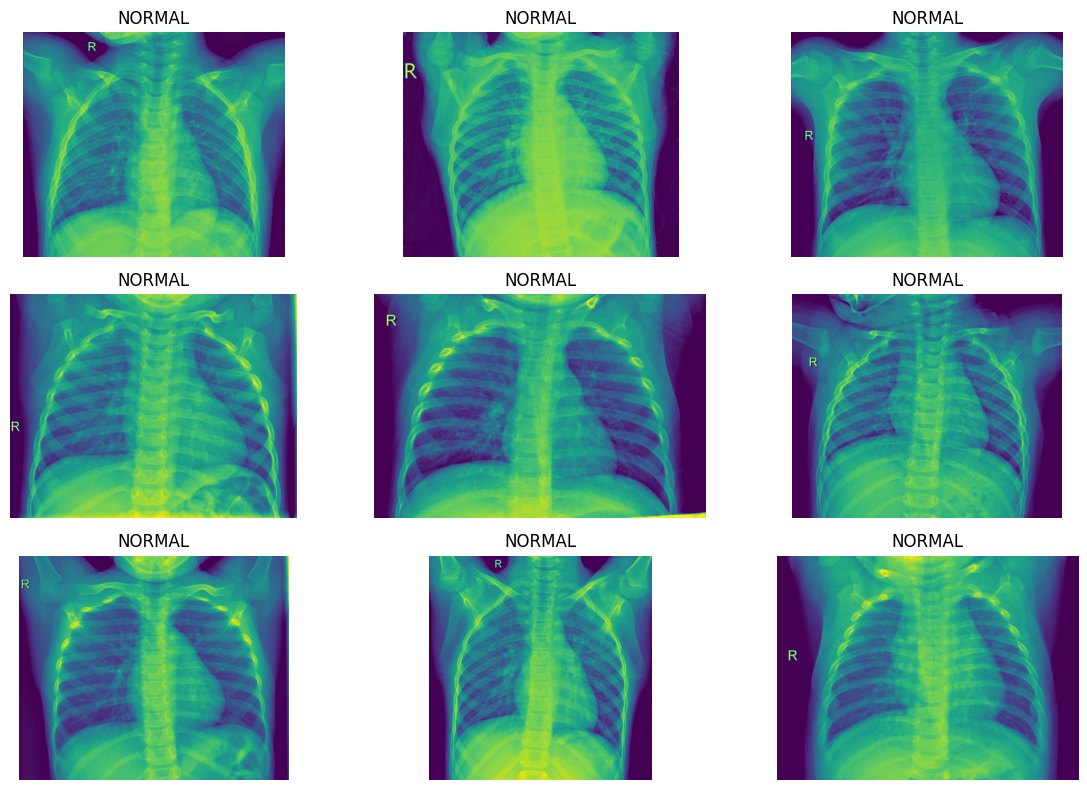

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Define data directory
data_dir = '/content/chest_xray'

# Create DataFrame with image paths and labels
image_paths = []
labels = []

for class_name in os.listdir(os.path.join(data_dir, 'train')):
    class_path = os.path.join(data_dir, 'train', class_name)
    for image_name in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, image_name))
        labels.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Display grid of images with labels
plt.figure(figsize=(12, 8))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    img = Image.open(df['image_path'][i])
    plt.imshow(img)
    plt.title(df['label'][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Data Loading and Processing, and Model Definition

In [ ]:
#todo
# 1. Load and preprocess the data.
# 2. Define the ResNet50-based classifier model.
# 3. Train the model on the training data.
# 4. Evaluate the model on the test data to obtain accuracy for each class.
# 5. Let's start by loading the necessary libraries and then proceed with each step.

import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define transforms for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Set data directory
data_dir = '/content/chest_xray'

# Create Datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

# Data Loaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Get Dataset Sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Get class names
class_names = image_datasets['train'].classes

# Load pre-trained ResNet50 model
model_ft = models.resnet50(pretrained=True)

# Freeze all layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with our own
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Normal and Pneumonia

# Move the model to the GPU if available
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

# Model Training

In [ ]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Train Model

In [ ]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Evaluate the model
model_ft.eval()
corrects = {classname: 0 for classname in class_names}
totals = {classname: 0 for classname in class_names}
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for label, prediction in zip(labels, preds):
            if label == prediction:
                corrects[class_names[label]] += 1
            totals[class_names[label]] += 1

# Calculate accuracy for each class
for classname, correct_count in corrects.items():
    accuracy = 100 * correct_count / totals[classname]
    print("Accuracy for class {}: {:.2f}%".format(classname, accuracy))

Epoch 0/9
----------
train Loss: 0.3460 Acc: 0.8581
test Loss: 0.3679 Acc: 0.8478

Epoch 1/9
----------
train Loss: 0.2691 Acc: 0.8852
test Loss: 0.3375 Acc: 0.8590

Epoch 2/9
----------
train Loss: 0.2551 Acc: 0.8928
test Loss: 0.4281 Acc: 0.8446

Epoch 3/9
----------
train Loss: 0.2629 Acc: 0.8909
test Loss: 0.4630 Acc: 0.8429

Epoch 4/9
----------
train Loss: 0.2570 Acc: 0.8919
test Loss: 0.5028 Acc: 0.8333

Epoch 5/9
----------
train Loss: 0.2509 Acc: 0.8957
test Loss: 0.5763 Acc: 0.8173

Epoch 6/9
----------
train Loss: 0.2520 Acc: 0.8905
test Loss: 0.3199 Acc: 0.8862

Epoch 7/9
----------
train Loss: 0.2234 Acc: 0.9062
test Loss: 0.3259 Acc: 0.8830

Epoch 8/9
----------
train Loss: 0.2295 Acc: 0.9089
test Loss: 0.3500 Acc: 0.8750

Epoch 9/9
----------
train Loss: 0.2106 Acc: 0.9135
test Loss: 0.3783 Acc: 0.8718

Best val Acc: 0.886218
Accuracy for class NORMAL: 78.63%
Accuracy for class PNEUMONIA: 94.62%


# Evaluation of Results
There are several reasons why this approach may attain higher accuracy compared to simpler methods:

1. **Transfer Learning with ResNet50**: The model uses a pretrained ResNet50 architecture as a feature extractor. ResNet50 is a deep CNN architecture known for its effectiveness in various computer vision tasks. By leveraging the features learned from the ImageNet dataset, which contains a vast number of diverse images, the model can generalize better to the X-ray images in the chest X-ray dataset.

2. **Data Augmentation**: Data augmentation techniques, such as random resizing and horizontal flipping, are applied to the training data. Data augmentation helps in increasing the diversity of the training dataset, which can improve the model's ability to generalize to unseen data and reduce overfitting.

3. **Normalization**: The input images are normalized using mean and standard deviation values computed from the ImageNet dataset. Normalization ensures that the input data has a consistent scale and distribution, which can facilitate the training process and improve convergence.

4. **Fine-Tuning**: Although the pretrained ResNet50 model's weights are frozen initially (except for the final fully connected layer), the model parameters are fine-tuned during training. This allows the model to adapt its representations to the specific characteristics of the chest X-ray dataset while still benefiting from the features learned from ImageNet.

5. **Optimization and Learning Rate Scheduling**: The model uses the Adam optimizer with a learning rate of 0.001 and a learning rate scheduler that reduces the learning rate by a factor of 0.1 every 7 epochs. Proper optimization techniques help in efficiently training the model and finding a good set of parameters that minimize the loss function.

6. **Evaluation on Test Set**: The model's performance is evaluated on a separate test set to assess its generalization ability accurately. This ensures that the reported accuracy is not overly optimistic due to overfitting to the training data.

By incorporating these techniques and leveraging the power of pretrained deep learning models like ResNet50, the provided code can achieve higher accuracy compared to simpler methods that may lack sophisticated architectures, data augmentation, or fine-tuning strategies.